In [1]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV #Perforing grid search

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 8

train = pd.read_csv('./data/train_modified.csv')
target = 'Disbursed'
IDCol = 'ID'

D:\Root\0-soft\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Root\0-soft\Anaconda3\envs\py27\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 我们先定义一个函数，它可以帮助我们建立XGBoost models 并进行交叉验证。

In [2]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='auc',
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    print cvresult
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
    # 原文中的alg.booster().get_fscore() 有问题，应该是版本的原因             
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## General Approach for Parameter Tuning

### We will use an approach similar to that of GBM here. The various steps to be performed are:

     1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
     2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
     3. Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
     4. Lower the learning rate and decide the optimal parameters .

### Let us look at a more detailed step by step approach:

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
### In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

    1. max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
    2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
    3. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
    4. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
    5. scale_pos_weight = 1: Because of high class imbalance.

### Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.765976      0.013069        0.770133       0.012637
1         0.795094      0.018332        0.801906       0.005170
2         0.802518      0.021473        0.809253       0.003740
3         0.809718      0.020259        0.818194       0.005978
4         0.811623      0.019163        0.822271       0.006356
5         0.813810      0.019506        0.826194       0.005169
6         0.814655      0.018285        0.828311       0.004954
7         0.816005      0.017583        0.830880       0.003984
8         0.816964      0.017261        0.832972       0.003711
9         0.817461      0.017140        0.833908       0.003598
10        0.817804      0.017065        0.834840       0.003575
11        0.818646      0.016362        0.837229       0.004365
12        0.819808      0.015585        0.838995       0.004677
13        0.821646      0.015360        0.841305       0.004869
14        0.821583      0.014471        

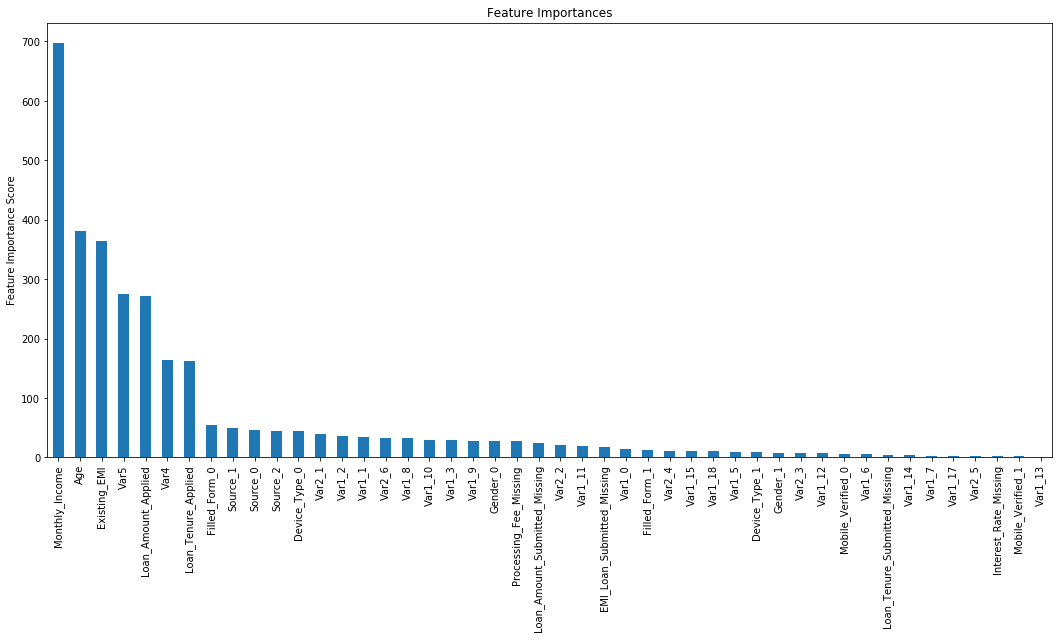

In [10]:
# Choose all predictors except target & IDClos
predictors = [x for x in train.columns if x not in [target, IDCol]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                     n_estimators = 1000,
                     max_depth = 5,
                     min_child_weight = 1,
                     gamma = 0,
                     subsample = 0.8,
                     colsample_bytree = 0.8,
                     objective = 'binary:logistic',
                     njobs = 4,
                     scale_pos_weight = 1,
                     random_state = 27)

modelfit(xgb1, train, predictors)

### Step 2: Tune max_depth and min_child_weight

In [5]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
xgb_estimator1 = XGBClassifier(learning_rate =0.1,
                               n_estimators=140,
                               max_depth=5,
                               min_child_weight=1,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'binary:logistic',
                               njobs=4,
                               scale_pos_weight=1,
                               random_state=27)
gsearch1 = GridSearchCV(estimator = xgb_estimator1, 
                        param_grid = param_test1,
                        scoring='roc_auc', n_jobs=4, iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83816, std: 0.01060, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83859, std: 0.00974, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83904, std: 0.00942, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84166, std: 0.00697, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84066, std: 0.00706, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84008, std: 0.00699, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83537, std: 0.00722, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83622, std: 0.00752, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83614, std: 0.00773, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82801, std: 0.00837, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.82850, std: 0.00676, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83001, std: 0.00623, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [6]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2,3]
}
xgb_estimator2 = XGBClassifier( learning_rate=0.1,
                               n_estimators=164,
                               max_depth=5,
                               min_child_weight=2,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'binary:logistic',
                               njobs=4,
                               scale_pos_weight=1,
                               random_state=27)
gsearch2 = GridSearchCV(estimator = xgb_estimator2,
                        param_grid = param_test2,
                        scoring='roc_auc',
                        n_jobs=4,iid=False,
                        cv=5)

gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84102, std: 0.00807, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.84242, std: 0.00728, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.84119, std: 0.00816, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.84076, std: 0.00662, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84142, std: 0.00825, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.84029, std: 0.00675, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.83819, std: 0.00602, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.83803, std: 0.00639, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.83713, std: 0.00702, params: {'max_depth': 6, 'min_child_weight': 3}],
 {'max_depth': 4, 'min_child_weight': 2},
 0.8424160581910256)

In [7]:
param_test2b = {
    'min_child_weight':[2,3,4]
}
xgb_estimator2b = XGBClassifier( learning_rate=0.1,
                                 n_estimators=164,
                                 max_depth=4,
                                 min_child_weight=2,
                                 gamma=0,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 objective= 'binary:logistic',
                                 njobs=4,
                                 scale_pos_weight=1,
                                 random_state=27)
gsearch2b = GridSearchCV(estimator = xgb_estimator2b, 
                         param_grid = param_test2b,
                         scoring='roc_auc',
                         n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.84242, std: 0.00728, params: {'min_child_weight': 2},
  mean: 0.84119, std: 0.00816, params: {'min_child_weight': 3},
  mean: 0.84105, std: 0.00826, params: {'min_child_weight': 4}],
 {'min_child_weight': 2},
 0.8424160581910256)

## Step 3: Tune gamma

### 在已经调整好其它参数的基础上，我们可以进行gamma参数的调优了。Gamma参数取值范围可以很大，我这里把取值范围设置为5了。你其实也可以取更精确的gamma值。

In [8]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
xgb_estimator3 = XGBClassifier(learning_rate =0.1,
                               n_estimators=164,
                               max_depth=4,
                               min_child_weight=2,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'binary:logistic',
                               njobs=4,
                               scale_pos_weight=1,
                               random_state=27)
gsearch3 = GridSearchCV(estimator = xgb_estimator3, 
                        param_grid = param_test3,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84242, std: 0.00728, params: {'gamma': 0.0},
  mean: 0.84020, std: 0.00733, params: {'gamma': 0.1},
  mean: 0.84169, std: 0.00758, params: {'gamma': 0.2},
  mean: 0.84104, std: 0.00780, params: {'gamma': 0.3},
  mean: 0.84105, std: 0.00791, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8424160581910256)

### This shows that our original value of gamma, i.e. 0 is the optimum one. 

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.765677      0.013255        0.769764       0.012785
1         0.793320      0.018878        0.800072       0.005711
2         0.801514      0.021823        0.807357       0.005247
3         0.808262      0.020087        0.816012       0.004790
4         0.810237      0.018621        0.819242       0.005079
5         0.811666      0.019644        0.822048       0.003725
6         0.813048      0.018035        0.824168       0.004073
7         0.813693      0.018688        0.825895       0.003546
8         0.815147      0.017614        0.827376       0.003260
9         0.815417      0.017704        0.827514       0.002934
10        0.815629      0.017750        0.827853       0.002965
11        0.816769      0.017178        0.829598       0.003392
12        0.817321      0.016321        0.830596       0.003813
13        0.819240      0.016195        0.832437       0.004638
14        0.819422      0.015039        

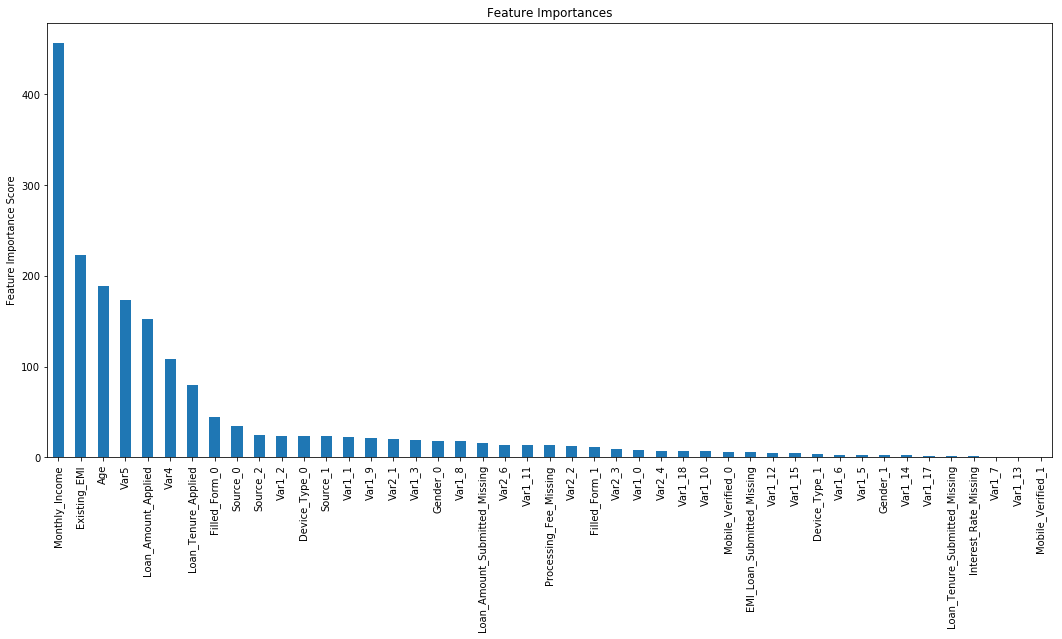

In [15]:
predictors = [x for x in train.columns if x not in [target, IDCol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        njobs=4,
        scale_pos_weight=1,
        random_state=27)
modelfit(xgb2, train, predictors)

## Here, we can see the improvement in score. So the final parameters are:
    max_depth: 4
    min_child_weight: 2
    gamma: 0

## Step 4: Tune subsample and colsample_bytree

### 下一步是尝试不同的subsample 和 colsample_bytree 参数。我们分两个阶段来进行这个步骤。这两个步骤都取0.6,0.7,0.8,0.9作为起始值。

In [16]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgb_estimator4 = XGBClassifier(learning_rate =0.1,
                               n_estimators=177,
                               max_depth=4,
                               min_child_weight=2,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'binary:logistic',
                               njobs=4,
                               scale_pos_weight=1,
                               random_state=27)
gsearch4 = GridSearchCV(estimator = xgb_estimator4, 
                        param_grid = param_test4,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=177,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [17]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83939, std: 0.00827, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.84122, std: 0.00762, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.84137, std: 0.00761, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.84289, std: 0.00638, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.84024, std: 0.00927, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.84028, std: 0.00792, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.84252, std: 0.00856, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.84156, std: 0.00803, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.83969, std: 0.00727, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.84149, std: 0.00845, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.84189, std: 0.00735, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.84124, std: 0.00859, params: {'subsample': 0.9, 'colsample_bytree'

### 从这里可以看出来，subsample 和 colsample_bytree 参数的理想取值分别是0.9和0.6。
### 现在，我们以0.05为步长，在这个值附近尝试取值。

In [5]:
predictors = [x for x in train.columns if x not in [target, IDCol]]
param_test4b = {
    'colsample_bytree':[i/100.0 for i in range(55,70,5)],
    'subsample':[i/100.0 for i in range(85,100,5)]
}
xgb_estimator4b = XGBClassifier(learning_rate =0.1,
                               n_estimators=177,
                               max_depth=4,
                               min_child_weight=2,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'binary:logistic',
                               njobs=4,
                               scale_pos_weight=1,
                               random_state=27)
gsearch4b = GridSearchCV(estimator = xgb_estimator4b, 
                        param_grid = param_test4b,
                        scoring='roc_auc',
                        n_jobs=4,iid=False,
                        cv=5)
gsearch4b.fit(train[predictors],train[target])

gsearch4b.grid_scores_, gsearch4b.best_params_, gsearch4b.best_score_

([mean: 0.84111, std: 0.00738, params: {'subsample': 0.85, 'colsample_bytree': 0.55},
  mean: 0.84011, std: 0.00694, params: {'subsample': 0.9, 'colsample_bytree': 0.55},
  mean: 0.84045, std: 0.00858, params: {'subsample': 0.95, 'colsample_bytree': 0.55},
  mean: 0.84158, std: 0.00621, params: {'subsample': 0.85, 'colsample_bytree': 0.6},
  mean: 0.84289, std: 0.00638, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.84328, std: 0.00719, params: {'subsample': 0.95, 'colsample_bytree': 0.6},
  mean: 0.84098, std: 0.00686, params: {'subsample': 0.85, 'colsample_bytree': 0.65},
  mean: 0.84271, std: 0.00820, params: {'subsample': 0.9, 'colsample_bytree': 0.65},
  mean: 0.84197, std: 0.00758, params: {'subsample': 0.95, 'colsample_bytree': 0.65}],
 {'colsample_bytree': 0.6, 'subsample': 0.95},
 0.8432804418059596)

### Again we got the same values as before. Thus the optimum values are:

    subsample: 0.95
    colsample_bytree: 0.6

## Step 5: Tuning Regularization Parameters

In [6]:
param_test5 = {
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
xgb_estimator5 = XGBClassifier(learning_rate =0.1,
                               n_estimators=177,
                               max_depth=4,
                               min_child_weight=2,
                               gamma=0,
                               subsample=0.95,
                               colsample_bytree=0.6,
                               objective= 'binary:logistic',
                               njobs=4,
                               scale_pos_weight=1,
                               random_state=27)
gsearch5 = GridSearchCV(estimator = xgb_estimator5, 
                        param_grid = param_test5,
                        scoring='roc_auc',
                        n_jobs=4,iid=False,
                        cv=5)
gsearch5.fit(train[predictors],train[target])

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84186, std: 0.00800, params: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05},
  mean: 0.84133, std: 0.00819, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.01},
  mean: 0.84206, std: 0.00690, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.1},
  mean: 0.84328, std: 0.00719, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.83623, std: 0.00878, params: {'reg_alpha': 1e-05, 'reg_lambda': 100},
  mean: 0.84246, std: 0.00717, params: {'reg_alpha': 0.01, 'reg_lambda': 1e-05},
  mean: 0.84122, std: 0.00803, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01},
  mean: 0.84213, std: 0.00845, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1},
  mean: 0.84267, std: 0.00738, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.83646, std: 0.00851, params: {'reg_alpha': 0.01, 'reg_lambda': 100},
  mean: 0.84207, std: 0.00746, params: {'reg_alpha': 0.1, 'reg_lambda': 1e-05},
  mean: 0.84298, std: 0.00624, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01},
  mean: 0.84311, std: 0.00678, params: {'reg

In [ ]:
param_test5b = {
    'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}
xgb_estimator5b = XGBClassifier(learning_rate =0.1,
                                n_estimators=177,
                                max_depth=4,
                                min_child_weight=2,
                                gamma=0,
                                subsample=0.95,
                                colsample_bytree=0.6,
                                objective= 'binary:logistic',
                                njobs=4,
                                scale_pos_weight=1,
                                random_state=27)
gsearch5b = GridSearchCV(estimator = xgb_estimator5b, 
                        param_grid = param_test5b,
                        scoring='roc_auc',
                        n_jobs=4,iid=False,
                        cv=5)
gsearch5b.fit(train[predictors],train[target])
gsearch5b.grid_scores_, gsearch5b.best_params_, gsearch5b.best_score_

## 可以看到，CV的得分提高了。现在，我们在模型中来使用正则化参数，来看看这个参数的影响。

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.776367      0.020105        0.782057       0.013402
1         0.796427      0.019129        0.800486       0.003433
2         0.803472      0.014779        0.808725       0.009124
3         0.808602      0.015940        0.814799       0.006567
4         0.811385      0.016019        0.817833       0.005433
5         0.812727      0.014869        0.820505       0.004059
6         0.815595      0.015397        0.824351       0.003049
7         0.816927      0.016082        0.826259       0.003453
8         0.817209      0.016218        0.828105       0.002713
9         0.816868      0.015455        0.828795       0.003005
10        0.816783      0.015869        0.829394       0.003679
11        0.817076      0.016369        0.830696       0.003095
12        0.818609      0.015053        0.832344       0.002958
13        0.820644      0.015414        0.833294       0.003213
14        0.820471      0.015426        

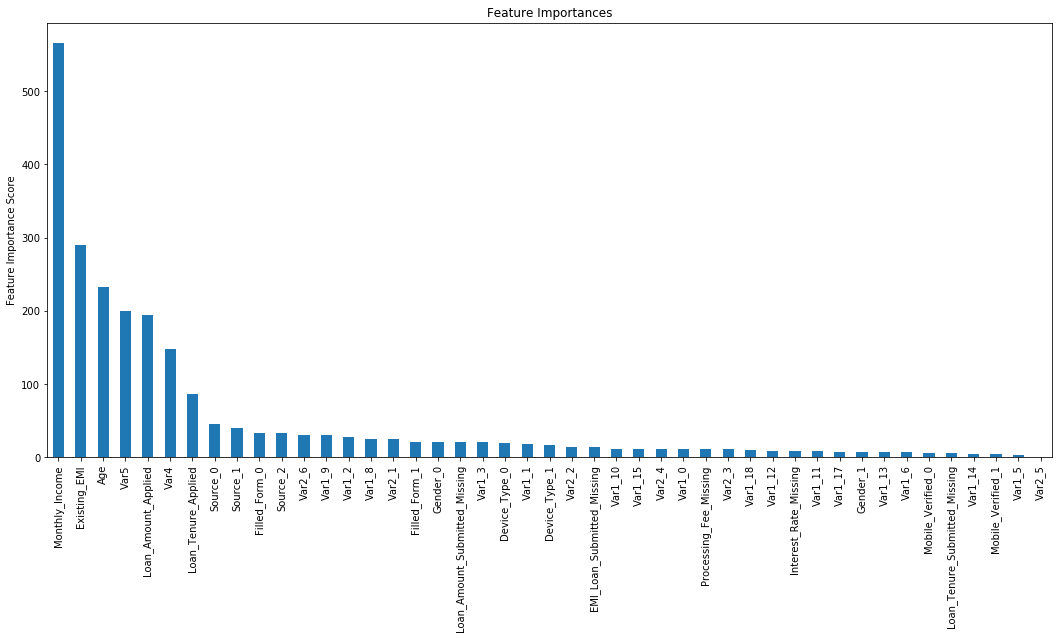

In [7]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=2,
        gamma=0,
        subsample=0.95,
        colsample_bytree=0.6,
        reg_alpha=1e-05,
        reg_lambda = 1,
        objective= 'binary:logistic',
        njobs=4,
        scale_pos_weight=1,
        random_state=27)
modelfit(xgb3, train, predictors)

## Step 6: Reducing Learning Rate

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.776367      0.020105        0.782057       0.013402
1          0.797220      0.018828        0.800204       0.004037
2          0.799069      0.013828        0.803361       0.007547
3          0.803871      0.014644        0.806098       0.006434
4          0.807000      0.013940        0.810239       0.005104
5          0.807414      0.015543        0.811268       0.004247
6          0.808663      0.015514        0.813633       0.004546
7          0.809175      0.016904        0.814332       0.004286
8          0.809383      0.017143        0.816141       0.004058
9          0.809519      0.016497        0.815844       0.005183
10         0.811242      0.016243        0.818301       0.003289
11         0.811198      0.016156        0.819376       0.002337
12         0.812313      0.015816        0.821099       0.002524
13         0.814921      0.016372        0.822331       0.002435
14         0.815463      

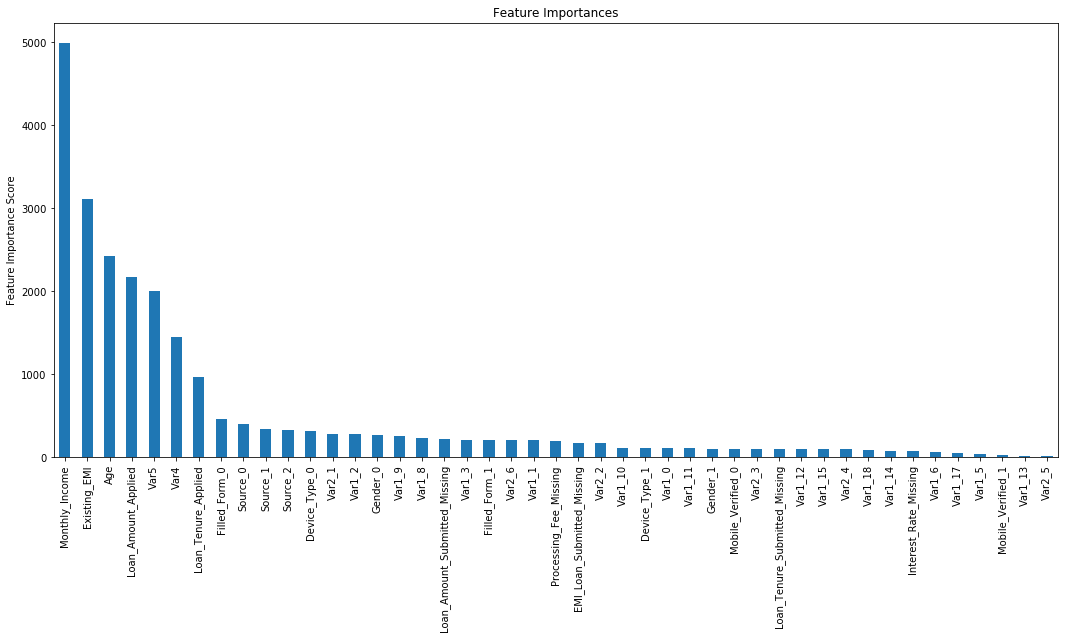

In [9]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=2,
        gamma=0,
        subsample=0.95,
        colsample_bytree=0.6,
        reg_alpha=1e-05,
        reg_lambda = 1,
        objective= 'binary:logistic',
        njobs=4,
        scale_pos_weight=1,
        random_state=27)
modelfit(xgb4, train, predictors)

## 至此，你可以看到模型的表现有了大幅提升，调整每个参数带来的影响也更加清楚了。 在文章的末尾，我想分享两个重要的思想： 
    1、仅仅靠参数的调整和模型的小幅优化，想要让模型的表现有个大幅度提升是不可能的。确实是有一定的提升，但是没有达到质的飞跃。 
    2、要想让模型的表现有一个质的飞跃，需要依靠其他的手段，诸如，特征工程(feature egineering) ，模型组合(ensemble of model),以及堆叠(stacking)等。